<a href="https://colab.research.google.com/github/Sandeepsabbella/Keras-Image-Classification-using-CNN/blob/master/Dogs_vs_Cats_classification_using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Dataset Dogs and Cats Classification Using Keras # version 2.2.4 
---

Direct Sharing link of Dataset: https://drive.google.com/drive/folders/1-2gVprcVKLaje1gsayxQgVFItyXgxvPn?usp=sharing 

***Dataset:*** The train folder contains 25,000 images of dogs and cats. Each image in this folder has the label as part of the filename. The test folder contains 12,500 images, named according to a numeric id. For each image in the test set, you should predict a probability that the image is a dog (1 = dog, 0 = cat)

**Setting a GPU accelerator on colab Notebook**

Runtime>Change Runtime Type> Select GPU in Hardware accelerator

**Instructions to be followed for running the code:**



1.   Make sure you have the Dataset in the drive. Add dataset into your drive.
2.   Run the code cells one by one in the numbering order mentioned for the cells below.



# New Section

In [0]:
# 1. For installing drive and geeting authorisation to access contents in drive

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

The cell below will ask for authentication by giving an URL. Click on the URL and enter the authentication code and click on 'Enter.'

In [0]:
# 2. For drive authentication

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Run these cells to fetch the data set and load ZIP files to the notebook memory

In [0]:
# 3.
fid = drive.ListFile({'q':"title='train.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('train.zip')

In [0]:
# 4.
fid = drive.ListFile({'q':"title='test.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('test.zip')

The following lines of code will make directories to store the unzipped files into the respective paths prescribed.

In [0]:
# 5.1
!mkdir -p drive
#!google-drive-ocamlfuse drive

In [0]:
# 5.2
!mkdir -p drive/tmp/train
!mkdir -p drive/tmp/test

In [0]:
# 5.3
!unzip test.zip -d drive/tmp/test
!unzip train.zip -d drive/tmp/train

Now we are all set with the directories and datasets loaded to their respective paths. We import the libraries needed and instantiate path and input shapes of images

In [0]:
# 6. importing Libraries required

import os
import cv2
import numpy as np
from tqdm import tqdm
from random import shuffle


import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras import backend as K
K.set_image_dim_ordering('th')


Trainset = 'drive/tmp/train/train'
Testset = 'drive/tmp/test/test'

input_x, input_y = 64,64  # (128,128) this is the input shape for the model and the shape extracted from images. Can be increased according to the layers in the model

ModelName = 'dogsvscats.model'

Using TensorFlow backend.


Defining funtions to read data from images and convert them into Numpy Arrays to pass into CNN architecture. I used open CV library to process the images into arrays for feeding into the network with required shape. The images were greyscaled for the efficiency and to reduce training time.

In [0]:
# 7. Functions for reading and processing Image data from Train and test folders

def labeling(image):
    labelled = image.split('.')[-3]
    if labelled == 'dog': return [1,0]
    elif labelled == 'cat': return [0,1]  # we can write a simple else and return as this is binary classification
  
def train_data_forming():
    train_data = []
    for image in tqdm(os.listdir(Trainset)):
      label = labeling(image)
      image = cv2.resize(cv2.imread(os.path.join(Trainset,image),0),(input_x,input_y))
      train_data.append([np.array(image),np.array(label)])
    shuffle(train_data)
    np.save('train_data.npy',train_data)
    return train_data

def test_data_forming():
    testing_data = []
    for image in tqdm(os.listdir(Testset)):
        image_num = image.split('.')[0]
        image = cv2.resize(cv2.imread(os.path.join(Testset,image),0),(input_x,input_y))
        testing_data.append([np.array(image), image_num])        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [0]:
# 8. storing values of arrays into traindata

train_data = train_data_forming()

#train_data = np.load('train_data.npy') # if the notebook have already stored as npy then use this

100%|██████████| 25000/25000 [00:27<00:00, 915.98it/s]


In [0]:
# 9. storing values of arrays into testdata

test_data = test_data_forming()

#test_data = np.load('test_data.npy')  # if the notebook have already stored as npy then use this

100%|██████████| 12500/12500 [00:13<00:00, 914.20it/s]


Defining the Keras Model for CNN keras Version: 2.2.4

1.   Optimiser selected is 'Adam' as it adjusts learning rate dynamically.
2.   Loss : Binary_Crossentropy  as there are only two classes of input.
3.   The architecture is adjusted to perform better on the dataset.



In [0]:
# 10. Keras Model for CNN

model = Sequential()
model.add(BatchNormalization(input_shape=(1,input_x,input_y)))
model.add(Conv2D(32, (3, 3), input_shape=(1, input_x, input_y), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2),strides=(2,2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2),strides=(2,2)))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2),strides=(2,2)))

#model.add(Conv2D(256, (3, 3), activation = 'relu'))            # we can add/Subtract these layers from CNN 
#model.add(MaxPooling2D(pool_size = (2, 2),strides=(2,2)))      # when there is increase in the input size of images

model.add(Flatten())

model.add(Dense(units = 512, activation = 'hard_sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(units = 2, activation = 'softmax'))

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 1, 64, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 62, 62)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 31)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 29, 29)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 12, 12)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 6, 6)          0         
__________

The following cells of code is implemented to incorporate Tensor Board into Keras model. Run these before cell by cell and click on the URL generated to see tensor board graphs for loss, accuracy etc.,.

In [0]:
# 11.1

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [0]:
# 11.2

LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
# 11.3
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
# 11.4
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://84e30164.ngrok.io


Running model to fit with the data. reshaped the train and test data accordingly to go through network appropriately. Included Tensor Board in the model.fit using callbacks for tensorboard logs

In [0]:
# 12 model fit for CNN and logs for Tensorboard

from keras.callbacks import TensorBoard

train = train_data[:-1500]
test = train_data[-1500:]

X_train = np.array([i[0] for i in train]).reshape(-1,1,input_x, input_y)
Y_train = np.array([i[1] for i in train]).reshape(-2,2)

X_test = np.array([i[0] for i in test]).reshape(-1,1,input_x, input_y)
Y_test = np.array([i[1] for i in test]).reshape(-2,2)

model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, Y_test),shuffle = True,
          callbacks = [TensorBoard(log_dir='./log', histogram_freq=0, batch_size=512, write_graph=True, update_freq='epoch')])

Train on 23500 samples, validate on 1500 samples
Epoch 1/20
23500/23500 [==============================] - 10s 431us/step - loss: 0.7561 - acc: 0.5400 - val_loss: 0.6578 - val_acc: 0.6113
Epoch 2/20
23500/23500 [==============================] - 5s 229us/step - loss: 0.6313 - acc: 0.6403 - val_loss: 0.5996 - val_acc: 0.6720
Epoch 3/20
23500/23500 [==============================] - 5s 229us/step - loss: 0.5701 - acc: 0.7010 - val_loss: 0.5405 - val_acc: 0.7167
Epoch 4/20
23500/23500 [==============================] - 5s 229us/step - loss: 0.5201 - acc: 0.7371 - val_loss: 0.5337 - val_acc: 0.7167
Epoch 5/20
23500/23500 [==============================] - 5s 230us/step - loss: 0.4828 - acc: 0.7662 - val_loss: 0.4891 - val_acc: 0.7653
Epoch 6/20
23500/23500 [==============================] - 5s 230us/step - loss: 0.4479 - acc: 0.7886 - val_loss: 0.4438 - val_acc: 0.7867
Epoch 7/20
23500/23500 [==============================] - 5s 229us/step - loss: 0.4326 - acc: 0.7981 - val_loss: 0.4407 - 

Saving the model.

In [0]:
model.save(ModelName)

In [0]:
if os.path.exists('{}.meta'.format(ModelName)):
    model.load(ModelName)

Plots to check the model performance and how well the model is predicting.

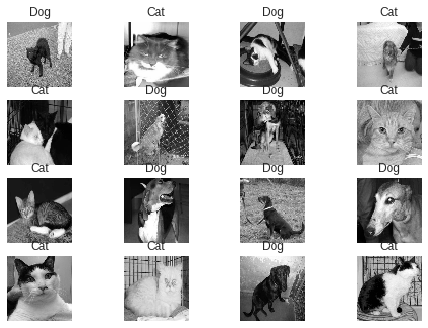

In [0]:
import matplotlib.pyplot as plt

#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:16]):
     
    img_data = data[0]
    
    y = fig.add_subplot(4,4,num+1)
    data = img_data.reshape(-1,1,input_x, input_y)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Cat'
    else: str_label='Dog'
        
    y.imshow(img_data,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [0]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

with open('/content/gdrive/My Drive/submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('/content/gdrive/My Drive/submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        data = img_data.reshape(-1,1,input_x, input_y)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))


In [0]:
# to check submission.csv values directly
!cat /content/gdrive/My\ Drive/submission_file.csv

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)